In [1]:
!pip install imagehash

    Markdown (>=3.0<3.3) ; python_version < "3.6"
             ~~~~~~^


In [2]:
import os
from pathlib import Path
from collections import defaultdict
import imagehash
from PIL import Image
import numpy as np
import torch
from torchvision import models, transforms
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

def find_hash_duplicates(dataset_folder: str, hash_size: int = 16):
    """
    Use pHash to catch exact / near-exact duplicates across all class folders.
    Returns a dict: {hash_str: [Path, Path, ...]} only for hashes seen >1×.
    """
    hashes = defaultdict(list)
    root = Path(dataset_folder)
    for img_path in root.rglob("*.*"):
        if not img_path.is_file():
            continue
        try:
            h = imagehash.phash(Image.open(img_path), hash_size=hash_size)
            hashes[str(h)].append(img_path)
        except Exception as e:
            print(f"⚠️  Couldn’t hash {img_path}: {e}")

    # filter out “unique” hashes
    return {h: paths for h, paths in hashes.items() if len(paths) > 1}


def compute_embeddings(dataset_folder: str, device="cuda"):
    """
    Walks all subfolders, runs every image through ResNet-18 (no FC)
    to get a 512-d embedding. Returns (paths, embeddings).
    """
    model = models.resnet18(pretrained=True)
    model.fc = torch.nn.Identity()
    model.eval().to(device)

    prep = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

    root = Path(dataset_folder)
    paths = [p for p in root.rglob("*.*") if p.is_file()]
    embs = []
    for p in tqdm(paths, desc="Embedding images"):
        img = Image.open(p).convert("RGB")
        x = prep(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model(x).cpu().numpy().flatten()
        embs.append(feat)

    return paths, np.vstack(embs)


def find_similar_pairs(dataset_folder: str,
                       threshold: float = 0.95,
                       device="cuda"):
    """
    Compute cosine similarity between all image embeddings under the dataset folder,
    and report any pairs above `threshold`.
    """
    paths, embs = compute_embeddings(dataset_folder, device=device)
    sims = cosine_similarity(embs)    # (N, N)
    N = len(paths)
    near_dups = []
    for i in range(N):
        for j in range(i):
            if sims[i, j] > threshold:
                near_dups.append((paths[i], paths[j], sims[i, j]))
    return near_dups



In [6]:
root = Path("DLCV_SS25_Dataset")
x = root.rglob("*.*")
print(f"Found {len(list(x))} files under {root}")

Found 2362 files under DLCV_SS25_Dataset


In [ ]:

DATASET = "DLCV_SS25_Dataset"

# 1) exact / near-exact duplicates
dups = find_hash_duplicates(DATASET)
print(f"Found {len(dups)} hash-groups with >1 images")
for h, group in dups.items():
    print(f"Hash {h}:")
    for p in group:
        print("   ", p)

# 2) visually similar pairs
pairs = find_similar_pairs(DATASET, threshold=0.96)
print(f"\nFound {len(pairs)} near-duplicate pairs (cosine > 0.96):")
for p1, p2, sim in pairs:
    print(f"{sim:.3f} → {p1}  <>  {p2}")


Found 4 hash-groups with >1 images
Hash ac2ced3d7bf30ec3a38671c67b18371cd870ca30ad8255d34af8a931dc234ec6:
    DLCV_SS25_Dataset\Angry\ANGRY_02_0027.png
    DLCV_SS25_Dataset\Angry\ANGRY_02_0058.png
Hash fe03ad42457cc4a547e1d29097d0d2816caf5702b17aed05e003fb96f61ff278:
    DLCV_SS25_Dataset\Angry\ANGRY_03_0122.png
    DLCV_SS25_Dataset\Angry\A_5_0092.png
Hash a9491a9ee142a73d1ec0e047a79c5cd3924de7691d25d9fa93512e2968f727c4:
    DLCV_SS25_Dataset\Angry\A_5_0026.png
    DLCV_SS25_Dataset\Neutral\N_5_0019.png
Hash adb43e5ff412726df8058bb6cd3005f735c113c3f3870196db0bc8b2c7d9408b:
    DLCV_SS25_Dataset\Angry\A_5_0106.png
    DLCV_SS25_Dataset\Sad\S_5_0106.png


c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Embedding images: 100%|██████████| 2362/2362 [00:21<00:00, 108.45it/s]



Found 16 near-duplicate pairs (cosine > 0.96):
1.000 → DLCV_SS25_Dataset\Angry\ANGRY_02_0058.png  <>  DLCV_SS25_Dataset\Angry\ANGRY_02_0027.png
0.960 → DLCV_SS25_Dataset\Angry\ANGRY_03_0118.png  <>  DLCV_SS25_Dataset\Angry\ANGRY_03_0078.png
0.961 → DLCV_SS25_Dataset\Angry\A_04_0096.png  <>  DLCV_SS25_Dataset\Angry\A_01_0045.png
1.000 → DLCV_SS25_Dataset\Angry\A_5_0092.png  <>  DLCV_SS25_Dataset\Angry\ANGRY_03_0122.png
0.968 → DLCV_SS25_Dataset\Happy\HAPPY_02_0153.png  <>  DLCV_SS25_Dataset\Happy\HAPPY_02_0088.png
0.965 → DLCV_SS25_Dataset\Happy\H_5_0077.png  <>  DLCV_SS25_Dataset\Happy\H_04_0055.png
0.961 → DLCV_SS25_Dataset\Neutral\N_01_0064.png  <>  DLCV_SS25_Dataset\Neutral\N_01_0063.png
0.973 → DLCV_SS25_Dataset\Neutral\N_5_0007.png  <>  DLCV_SS25_Dataset\Angry\A_04_0073.png
1.000 → DLCV_SS25_Dataset\Neutral\N_5_0019.png  <>  DLCV_SS25_Dataset\Angry\A_5_0026.png
0.965 → DLCV_SS25_Dataset\Sad\S_08_0093.png  <>  DLCV_SS25_Dataset\Sad\SAD_03_0025.png
0.975 → DLCV_SS25_Dataset\Sad\S_5

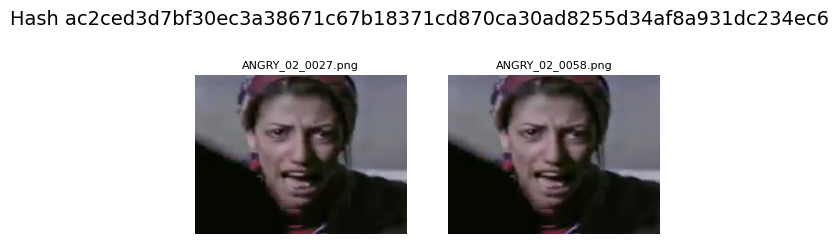

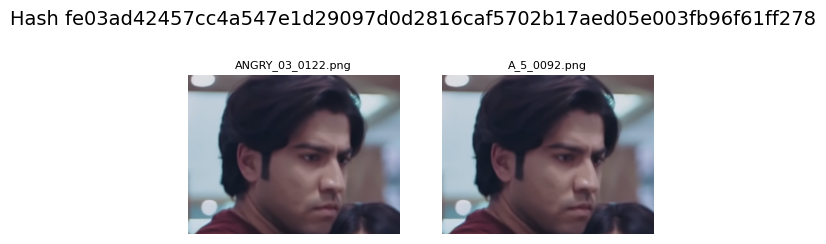

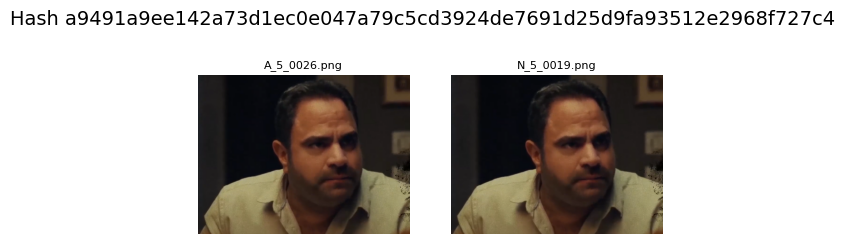

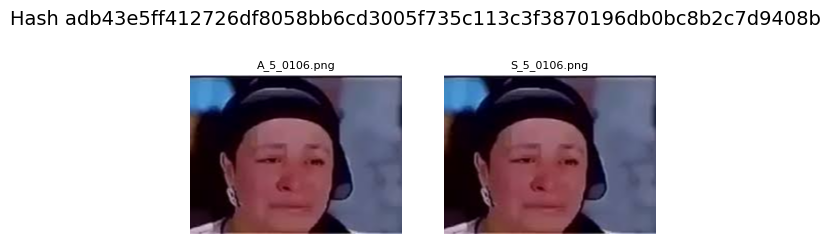

In [8]:
import matplotlib.pyplot as plt
for h, group in dups.items():
    fig, axes = plt.subplots(1, len(group), figsize=(3*len(group), 3))
    if len(group) == 1:
        axes = [axes]
    fig.suptitle(f"Hash {h}", fontsize=14)
    for ax, path in zip(axes, group):
        img = Image.open(path).convert("RGB")
        ax.imshow(img)
        ax.set_title(path.name, fontsize=8)
        ax.axis('off')
    plt.show()



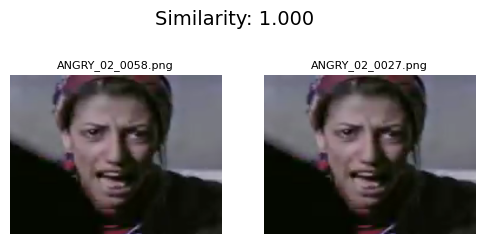

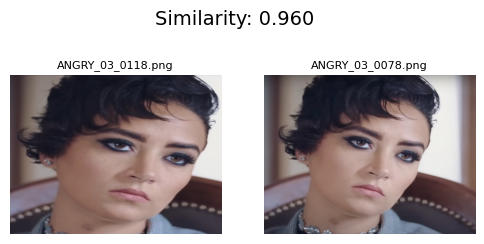

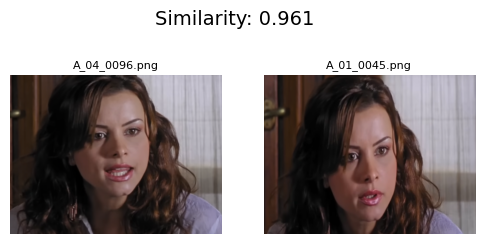

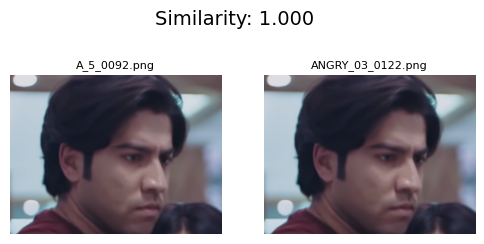

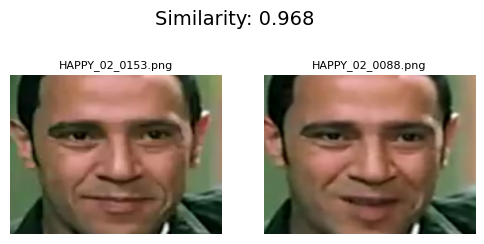

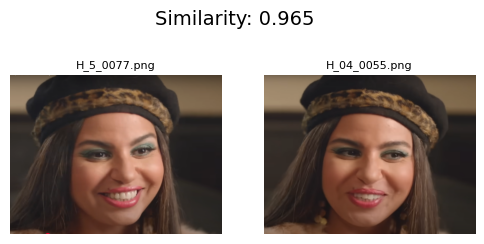

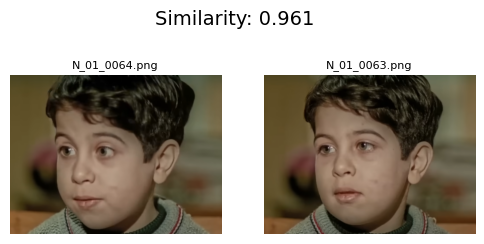

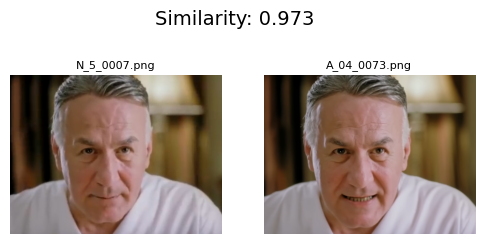

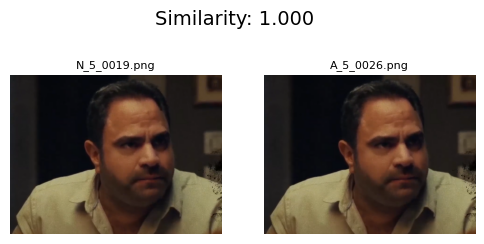

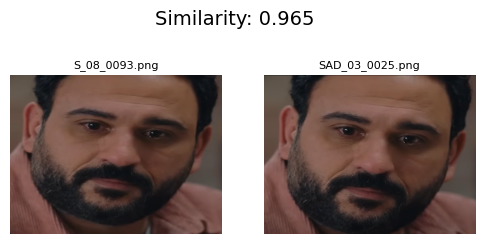

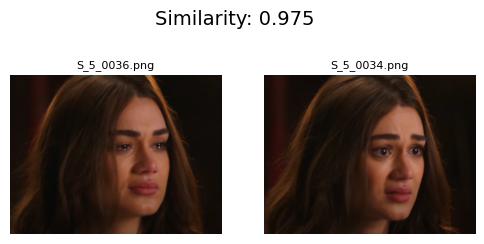

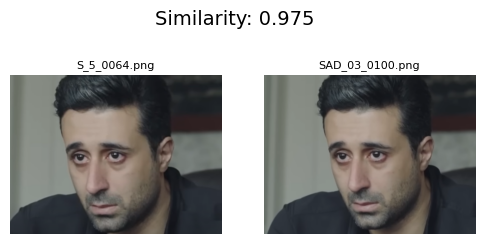

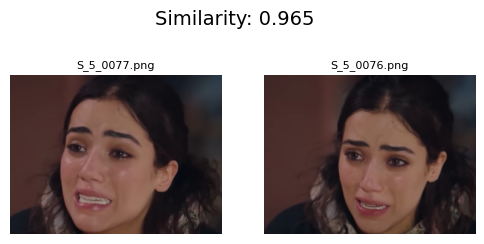

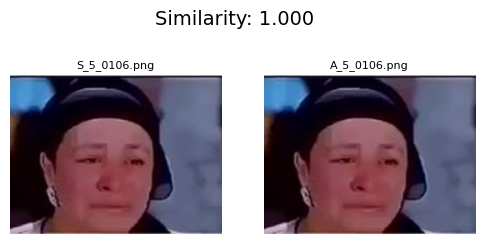

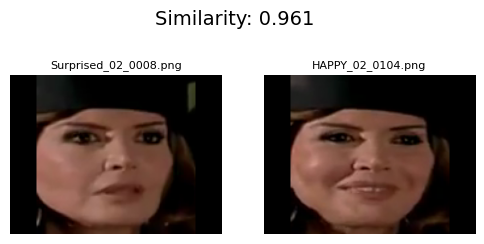

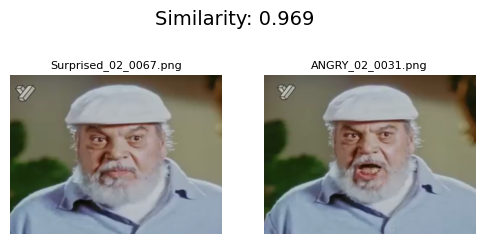

In [9]:
for (p1, p2, sim) in pairs:
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(f"Similarity: {sim:.3f}", fontsize=14)
    img1 = Image.open(p1).convert("RGB")
    img2 = Image.open(p2).convert("RGB")
    axes[0].imshow(img1); axes[0].set_title(p1.name, fontsize=8); axes[0].axis('off')
    axes[1].imshow(img2); axes[1].set_title(p2.name, fontsize=8); axes[1].axis('off')
    plt.show()

In [10]:
len(pairs)

16